In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [14]:
# Read data
file_path = "CAISO_zone_1_2019_TimeFeatures.csv"
data = pd.read_csv(file_path)

In [15]:
# Make sure the date column is in date format
data['Date'] = pd.to_datetime(data['Date'])

In [16]:
# Select feature variables
selected_features = [
    'Wind_power', 'Solar_power', 'DHI', 'DNI', 'GHI', 'Temperature',
    'Relative humidity', 'Wind speed', 'Rain/Drizzle', 'Snow/Ice Pellets', 'Thunder',
    'Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos','Dew point', 'Solar zenith angle', 'SLP',
    'STP', 'VISIB', 'PRCP', 'Fog'
]

# Extract features and target variables
features = data[selected_features]
target = data['Load_power']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [19]:
best_params = grid_search.best_params_

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=42
)

In [20]:
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

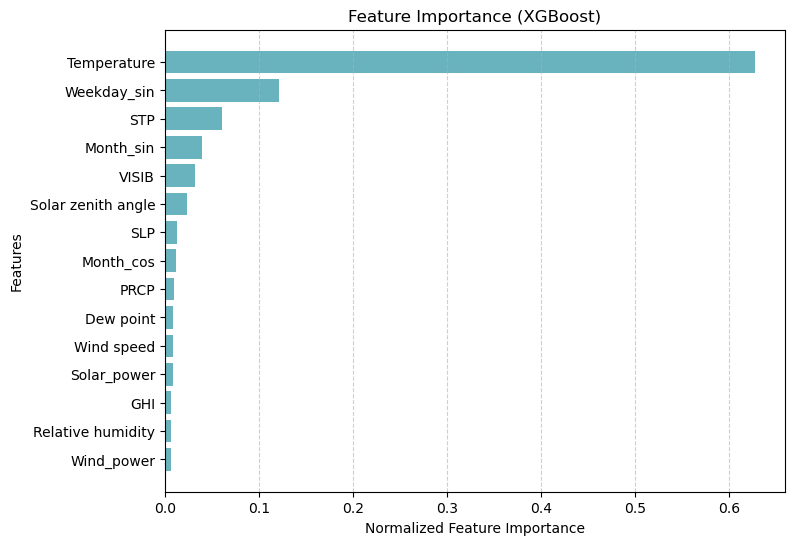

Chart has been saved to: E:/Desktop/Feature_Importance_XGBoost.png

Top 15 Feature Importance (Normalized, Sorted):
Temperature: 0.6284
Weekday_sin: 0.1214
STP: 0.0613
Month_sin: 0.0390
VISIB: 0.0318
Solar zenith angle: 0.0237
SLP: 0.0126
Month_cos: 0.0120
PRCP: 0.0099
Dew point: 0.0091
Wind speed: 0.0090
Solar_power: 0.0085
GHI: 0.0070
Relative humidity: 0.0067
Wind_power: 0.0061


In [21]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Normalize feature importance (L1 normalization so that sum = 1)
normalized_importance = feature_importances / feature_importances.sum()

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances,
    "Normalized Importance": normalized_importance
})

# Sort by normalized importance in descending order (most important first)
importance_df = importance_df.sort_values(by="Normalized Importance", ascending=False)

# Select only the top 15 most important features
top_15_features = importance_df.head(15)

# Plot horizontal bar chart for the top 15 features (normalized importance)
plt.figure(figsize=(8, 6))
plt.barh(top_15_features["Feature"], top_15_features["Normalized Importance"], color='#69b3be')
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance (XGBoost)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Ensure the most important feature is on top

# Save the plot
output_file_path = "E:/Desktop/Feature_Importance_XGBoost.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Chart has been saved to: {output_file_path}")

# Print only the top 15 features with normalized importance
print("\nTop 15 Feature Importance (Normalized, Sorted):")
for _, row in top_15_features.iterrows():
    print(f"{row['Feature']}: {row['Normalized Importance']:.4f}")

In [26]:
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = (abs((y_train - y_train_pred) / y_train).mean()) * 100

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = (abs((y_test - y_test_pred) / y_test).mean()) * 100

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Training R² Score: {train_r2}")
print(f"Training Mean Absolute Error (MAE): {train_mae}")
print(f"Training Mean Absolute Percentage Error (MAPE): {train_mape:.2f}%")

print(f"Testing Mean Squared Error (MSE): {test_mse}")
print(f"Testing R² Score: {test_r2}")
print(f"Testing Mean Absolute Error (MAE): {test_mae}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {test_mape:.2f}%")

Training Mean Squared Error (MSE): 4.698232954677799e-05
Training R² Score: 0.997505525423173
Training Mean Absolute Error (MAE): 0.0052321557548934035
Training Mean Absolute Percentage Error (MAPE): 0.54%
Testing Mean Squared Error (MSE): 0.0006885152409450373
Testing R² Score: 0.9643509186918503
Testing Mean Absolute Error (MAE): 0.01996508855564156
Testing Mean Absolute Percentage Error (MAPE): 1.98%


In [27]:
train_results = pd.DataFrame({
    "Date": data.loc[y_train.index, 'Date'], 
    "Actual": y_train.values,
    "Predicted": y_train_pred
})

test_results = pd.DataFrame({
    "Date": data.loc[y_test.index, 'Date'], 
    "Actual": y_test.values,
    "Predicted": y_test_pred
})

results = pd.concat([train_results, test_results])
results_sorted = results.sort_values(by='Date')

预测结果已保存到 XGBoost_Predictions.csv
Time Series plot saved at: E:/Desktop/Actual_vs_Predicted_Over_Time_XGBoost.png


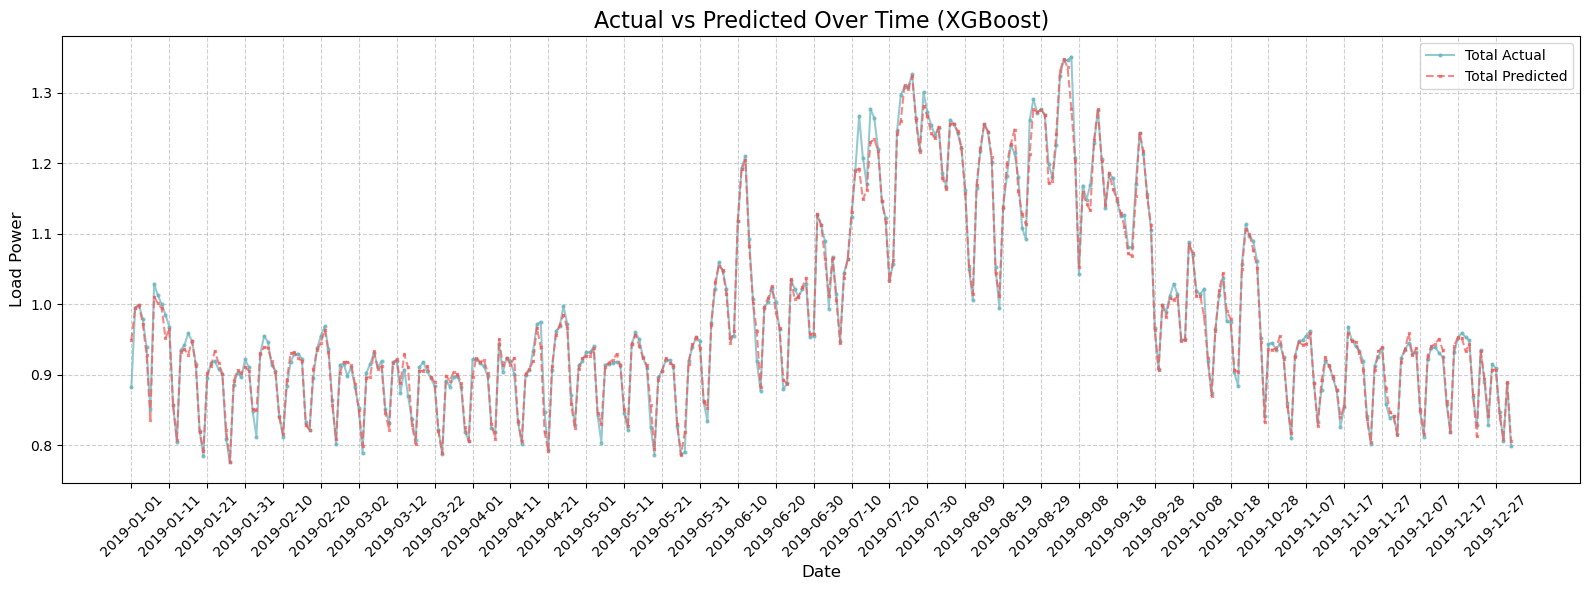

In [28]:
output_file = "XGBoost_Predictions.csv"
results_sorted.to_csv(output_file, index=False)
print(f"预测结果已保存到 {output_file}")

plt.figure(figsize=(16, 6))
plt.plot(results_sorted["Date"], results_sorted["Actual"], label="Total Actual", linestyle='-', marker='o', markersize=2, alpha=0.7,color='#69b3be')
plt.plot(results_sorted["Date"], results_sorted["Predicted"], label="Total Predicted", linestyle='--', marker='x', markersize=2, alpha=0.7, color='#f05756')
plt.title("Actual vs Predicted Over Time (XGBoost)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Load Power", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(results_sorted["Date"][::10], rotation=45) 
plt.tight_layout()

output_file_path_time_series = "E:/Desktop/Actual_vs_Predicted_Over_Time_XGBoost.png"
plt.savefig(output_file_path_time_series, dpi=300, bbox_inches='tight')
print(f"Time Series plot saved at: {output_file_path_time_series}")

plt.show()

Scatter plot saved at: E:/Desktop/Scatter_Plot_Actual_vs_Predicted_XG.png


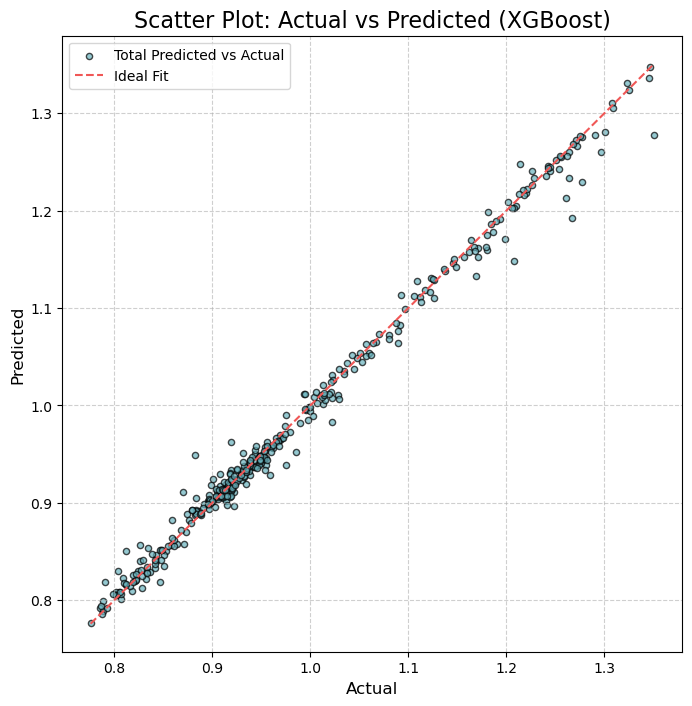

In [29]:
plt.figure(figsize=(8, 8))

plt.scatter(
    results_sorted["Actual"], 
    results_sorted["Predicted"], 
    alpha=0.7, 
    edgecolor='k',
    color='#69b3be', 
    s=20, 
    label="Total Predicted vs Actual"
)

plt.plot(
    [results_sorted["Actual"].min(), results_sorted["Actual"].max()], 
    [results_sorted["Actual"].min(), results_sorted["Actual"].max()], 
     '--', label="Ideal Fit" ,color='#f05756'
)

plt.title("Scatter Plot: Actual vs Predicted (XGBoost)", fontsize=16)
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

output_file_path_scatter = "E:/Desktop/Scatter_Plot_Actual_vs_Predicted_XG.png"
plt.savefig(output_file_path_scatter, dpi=300, bbox_inches='tight')
print(f"Scatter plot saved at: {output_file_path_scatter}")


plt.show()

Residual plot saved at: E:/Desktop/Residual_Plot_Over_Time_XG.png


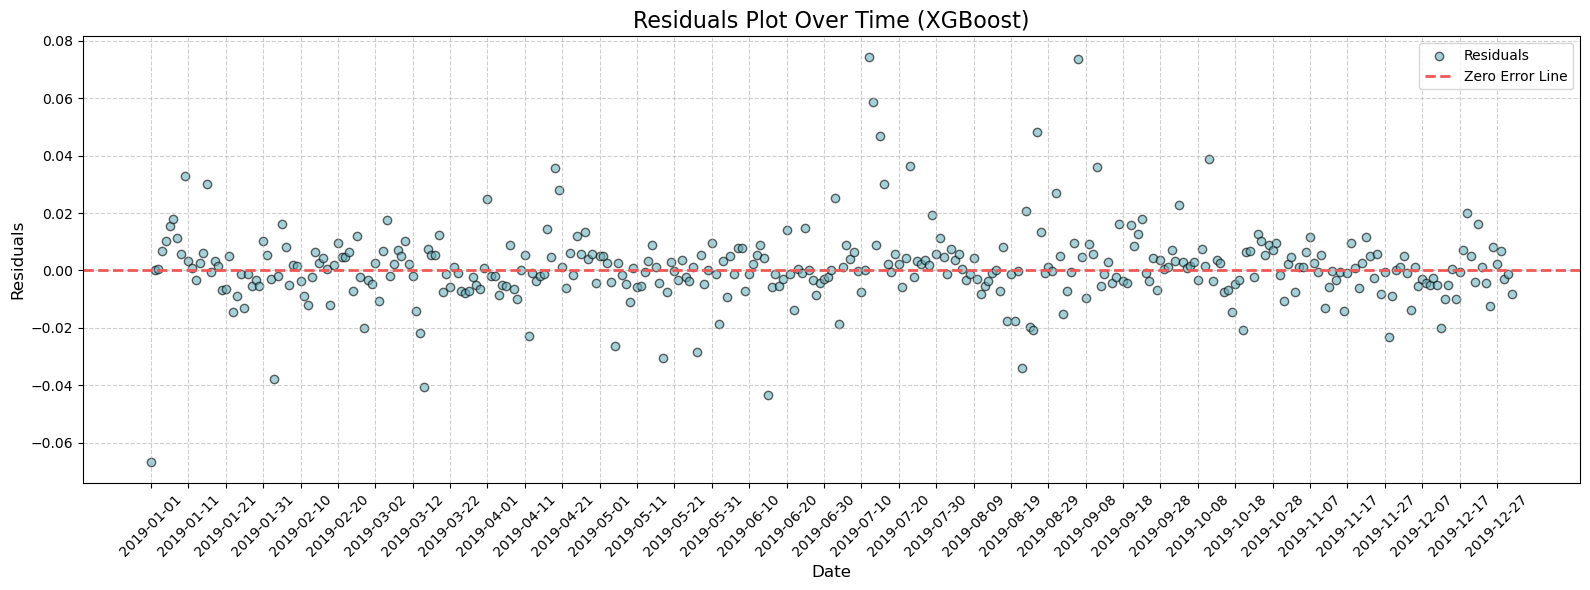

In [30]:
results_sorted['Residuals'] = results_sorted["Actual"] - results_sorted["Predicted"]

plt.figure(figsize=(16, 6))
plt.scatter(results_sorted["Date"], results_sorted["Residuals"], alpha=0.6, edgecolor='k', label="Residuals", color='#69b3be')
plt.axhline(y=0, color='#f05756', linestyle='--', linewidth=2, label="Zero Error Line")
plt.title("Residuals Plot Over Time (XGBoost)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.xticks(results_sorted["Date"][::10], rotation=45) 
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

output_file_path_residual = "E:/Desktop/Residual_Plot_Over_Time_XG.png"
plt.savefig(output_file_path_residual, dpi=300, bbox_inches='tight')
print(f"Residual plot saved at: {output_file_path_residual}")

plt.show()